<a href="https://colab.research.google.com/github/MereumF/EMBSEEGCOMP/blob/main/BasicDataProcessing__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)

CUDA-enabled GPU found. Training should be faster.


In [2]:
#@title ▶️ Install additional required packages for colab
!pip install braindecode
!pip install eegdash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 134.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.

In [4]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R1", cache_dir=DATA_DIR,
                                  mini=True)


/usr/local/lib/python3.12/dist-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


In [5]:
print("Type: ", type(dataset_ccd))
print("Directory: ", dir(dataset_ccd))


Type:  <class 'eegdash.dataset.dataset.EEGChallengeDataset'>
Directory:  ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_datasets', '_find_key_in_nested_dict', '_find_local_bids_records', '_get_sequence', '_outdated_save', '_save_description', '_save_kwargs', '_save_metadata', '_save_signals', '_save_target_name', '_target_transform', 'cache_dir', 'cummulative_sizes', 'cumsum', 'cumulative_sizes', 'data_dir', 'datasets', 'description', 'download', 'eeg_dash_instance', 'filesystem', 'get_metadata', 'mini', 'n_jobs', 'query', 'records', 'release', 's3_bucket', 's

In [15]:
raw = dataset_ccd.datasets[0].raw  # get the Raw object of the first recording, only has EEG data
print("Type: ", type(raw))
print("Length: ", len(raw))


Type:  <class 'mne.io.edf.edf.RawEDF'>
Length:  23500


In [7]:
#https://neuraldatascience.io/7-eeg/mne_python.html

Using matplotlib as 2D backend.


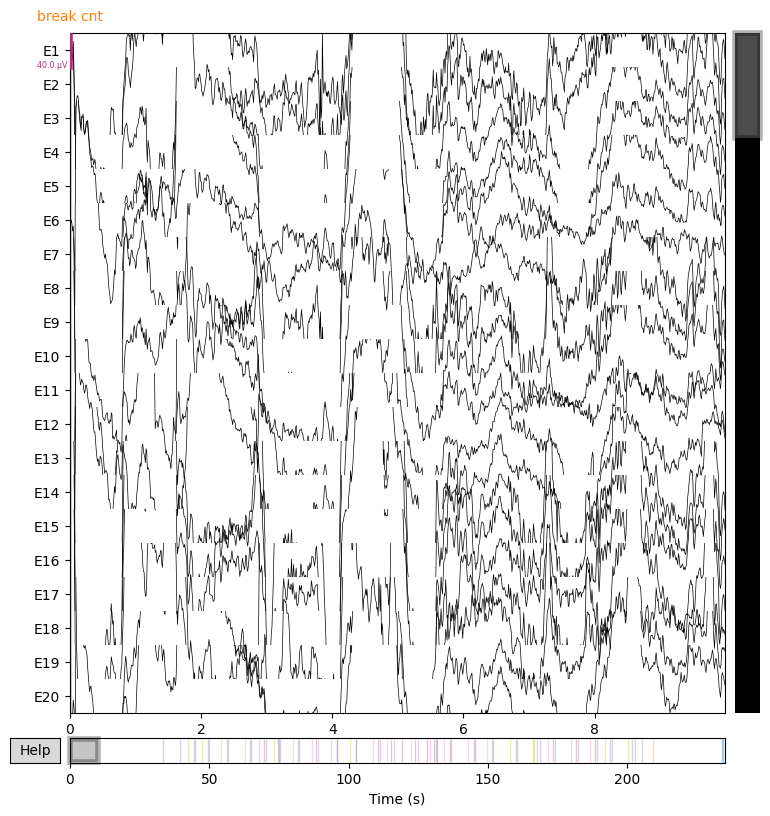

In [8]:
fig = raw.plot()

In [10]:
#@title ▶️ Run this first to get all the utils functions for the epoching
from braindecode.datasets import BaseConcatDataset


In [28]:
#Challenge 1 starter kit
#0.5 sec = 500 ms
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

In [40]:
# for each windows, we can extract the metainformation using:

meta_information = single_windows.get_metadata()
meta_information.head()


,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,4278,4478,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,4798,4998,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,5478,5678,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,6318,6518,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,6838,7038,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


In [32]:
print(meta_information.isna().sum())

i_window_in_trial            0
i_start_in_trial             0
i_stop_in_trial              0
target                       0
rt_from_stimulus             0
rt_from_trialstart           0
stimulus_onset               0
response_onset               0
correct                      0
response_type                0
subject                      0
run                          0
task                         0
age                          0
sex                          0
release_number               0
ehq_total                    0
commercial_use               0
full_pheno                   0
p_factor                     0
attention                    0
internalizing                0
externalizing                0
restingstate                 0
despicableme                 0
funwithfractals              0
thepresent                   0
diaryofawimpykid             0
contrastchangedetection_1    0
contrastchangedetection_2    0
contrastchangedetection_3    0
surroundsupp_1               0
surround

In [75]:
import pandas as pd

for i in meta_information:
  meta_cleaned = meta_information.copy()
  meta_cleaned = meta_cleaned.replace("unavailable", pd.NA)
  meta_cleaned = meta_cleaned.dropna().reset_index(drop=True)
print("Original rows: ", len(meta_information))
print("Rows after cleaning: ", len(meta_cleaned))


Original rows:  1513
Rows after cleaning:  0


In [120]:
import numpy as np
male = 0
female = 0

subject_ids = meta_information["subject"].unique()
print("Subject ID's: ", subject_ids)
print("Ages: ", meta_information["age"].unique())

participants_summary = meta_information[['subject', 'sex']].drop_duplicates()

for i in participants_summary['sex']:
  if i == 'M':
    male +=1
  elif i == 'F':
    female +=1
print("Num of Males: ", male, ". Num of Females: ", female)


Subject ID's:  ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5'
 'NDARCJ594BWQ' 'NDARCN669XPR' 'NDARCW094JCG' 'NDARCZ947WU5'
 'NDARDH670PXH' 'NDARDL511UND' 'NDARDU986RBM' 'NDAREM731BYM'
 'NDAREN519BLJ' 'NDARFK610GY5' 'NDARFT581ZW5' 'NDARFW972KFQ']
Ages:  [11.3386 10.9449 12.8422 13.9757  8.6883  8.3652  6.7472  6.6821 12.4585
  9.6883  8.453   9.3646 13.0092 10.2002  9.926  11.8507  7.0291 10.5204
  6.7034 12.4397]
Num of Males:  12 . Num of Females:  8


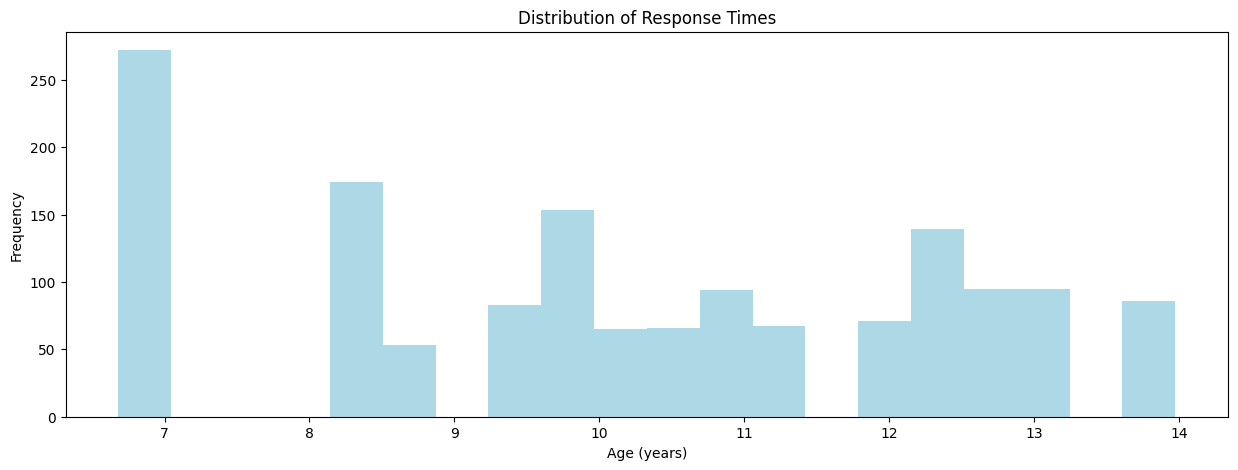

In [101]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["age"].plot.hist(bins=20, ax=ax, color='lightblue')
ax.set_xlabel("Age (years)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()


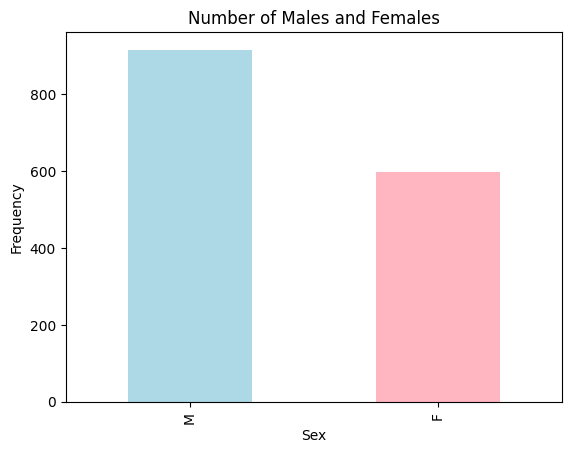

In [124]:
sex_counts = meta_information['sex'].value_counts()

sex_counts.plot(kind='bar', color=['lightblue', 'lightpink'])
plt.xlabel("Sex")
plt.ylabel("Frequency")
plt.title("Number of Males and Females")
plt.show()

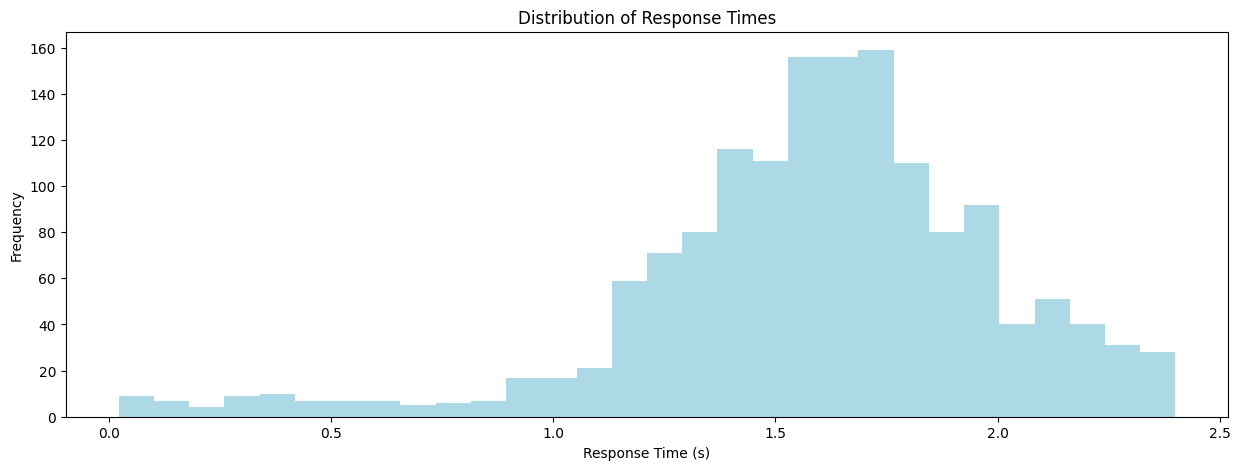

In [42]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()


In [127]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()

train_subj, valid_test_subject = train_test_split(
    subjects, test_size=(valid_frac + test_frac), random_state=check_random_state(seed), shuffle=True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, random_state=check_random_state(seed + 1), shuffle=True
)
# sanity check
assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

In [130]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

print(f"Sanity Check: {len(train_set) + len(valid_set) + len(test_set)} = {len(meta_information)}" )

Number of examples in each split in the minirelease
Train:	1187
Valid:	244
Test:	82
Sanity Check: 1513 = 1513


In [132]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 128 #samples used before updating parameters
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

sex = meta_information["sex"]
target = meta_information["target"]

#Build the model
svm = SVC(kernel="sigmoid", gamma=0.1, C=1.0)
# Trained the model
svm.fit(meta_information[], y_train_adhd)


In [133]:
#THE DEEP LEARNING MODEL
from braindecode.models.util import models_dict

names = sorted(models_dict)
w = max(len(n) for n in names)

for i in range(0, len(names), 3):
    row = names[i:i+3]
    print("  ".join(f"{n:<{w}}" for n in row))

ATCNet                  AttentionBaseNet        AttnSleep             
BDTCN                   BIOT                    CTNet                 
ContraWR                Deep4Net                DeepSleepNet          
EEGConformer            EEGITNet                EEGInceptionERP       
EEGInceptionMI          EEGMiner                EEGNeX                
EEGNet                  EEGSimpleConv           EEGTCNet              
FBCNet                  FBLightConvNet          FBMSNet               
IFNet                   Labram                  MSVTNet               
SCCNet                  SPARCNet                ShallowFBCSPNet       
SignalJEPA              SignalJEPA_Contextual   SignalJEPA_PostLocal  
SignalJEPA_PreLocal     SincShallowNet          SleepStagerBlanco2020 
SleepStagerChambon2018  SyncNet                 TIDNet                
TSception               USleep                


In [136]:
# for any braindecode model, you can initialize only inputing the signal related parameters
from braindecode.models import Deep4Net

model = Deep4Net(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )

/usr/local/lib/python3.12/dist-packages/braindecode/models/deep4.py:167: UserWarning: n_times (200) is smaller than the minimum required (441) for the current model parameters configuration. Adjusting parameters to ensure compatibility.Reducing the kernel, pooling, and stride sizes accordingly.Scaling factor: 0.45
  warn(


In [137]:
# the braindecode models have this convenient way to initialize with just the signal parameters
# and also some eegmodulemixin that allow to easily torch info once the model is created

print(model)

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
Deep4Net (Deep4Net)                           [1, 129, 200]             [1, 1]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 129, 200]             [1, 129, 200, 1]          --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 129, 200, 1]          [1, 1, 200, 129]          --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 200, 129]          [1, 25, 191, 1]           80,900                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 25, 191, 1]           [1, 25, 191, 1]           50                        --
├─ELU (conv_nonlin): 1-5                      [1, 25, 191, 1]           [1, 25, 191, 1]           --                        --
├─MaxPool2d (pool): 1-6                       [1, 25, 191, 1]           [1, 25, 191, 1]           -- 

In [143]:
#PYTORCH TRAINING PIPELINE
# Defining training parameters

lr = 1E-3
weight_decay = 1E-5
n_epochs = 5
early_stopping_patience = 2

In [145]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler

# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        # Support datasets that may return (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

In [146]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        # Supports (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()
        # casting X to float32

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse


In [147]:
import copy

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)
loss_fn = torch.nn.MSELoss()

patience = 5
min_delta = 1e-4
best_rmse = float("inf")
epochs_no_improve = 0
best_state, best_epoch = None, None

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device
    )
    val_loss, val_rmse = valid_model(test_loader, model, loss_fn, device)

    print(
        f"Train RMSE: {train_rmse:.6f}, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Val RMSE: {val_rmse:.6f}, "
        f"Average Val Loss: {val_loss:.6f}"
    )

    if val_rmse < best_rmse - min_delta:
        best_rmse = val_rmse
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val RMSE: {best_rmse:.6f} (epoch {best_epoch})")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1/5: 

Epoch 1, Batch 10/10, Loss: 1.452990, RMSE: 1.764825: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]
Val Batch 1/1, Loss: 2.674679, RMSE: 1.635445: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

Val RMSE: 1.635445, Val Loss: 2.674679

Train RMSE: 1.764825, Average Train Loss: 2.993882, Val RMSE: 1.635445, Average Val Loss: 2.674679
Epoch 2/5: 


Epoch 2, Batch 10/10, Loss: 1.863724, RMSE: 1.803521: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
Val Batch 1/1, Loss: 0.638826, RMSE: 0.799266: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

Val RMSE: 0.799266, Val Loss: 0.638826

Train RMSE: 1.803521, Average Train Loss: 3.151772, Val RMSE: 0.799266, Average Val Loss: 0.638826
Epoch 3/5: 


Epoch 3, Batch 10/10, Loss: 1.129728, RMSE: 1.311304: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]
Val Batch 1/1, Loss: 2.019995, RMSE: 1.421265: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

Val RMSE: 1.421265, Val Loss: 2.019995

Train RMSE: 1.311304, Average Train Loss: 1.676665, Val RMSE: 1.421265, Average Val Loss: 2.019995
Epoch 4/5: 


Epoch 4, Batch 10/10, Loss: 2.526568, RMSE: 1.350403: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]
Val Batch 1/1, Loss: 0.641417, RMSE: 0.800885: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

Val RMSE: 0.800885, Val Loss: 0.641417

Train RMSE: 1.350403, Average Train Loss: 1.874663, Val RMSE: 0.800885, Average Val Loss: 0.641417
Epoch 5/5: 


Epoch 5, Batch 10/10, Loss: 1.229179, RMSE: 1.130704: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
Val Batch 1/1, Loss: 0.355156, RMSE: 0.595950: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

Val RMSE: 0.595950, Val Loss: 0.355156

Train RMSE: 1.130704, Average Train Loss: 1.274909, Val RMSE: 0.595950, Average Val Loss: 0.355156


In [148]:
# saving the model

torch.save(model.state_dict(), "model.pth")
